# Functions

In [69]:
%run "initialization.ipynb"
%run "Input_selection_functions.ipynb"
%run "Downsampling_and_outliers_functions.ipynb"
%run "Stitching_clean.ipynb"
%run "Visualization_functions.ipynb"
%run "Evaluation_functions.ipynb"

%load_ext autoreload

----------------------------------------
loaded variables from initialization file: 
> myparams, myconfiguration_file
> list_picked_id_source, list_picked_id_target
> data_folder
----------------------------------------
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### just some handpicked visualization settings for this page

they are fed in "custom_draw_geometry" as for params, ad myconfiguration. 
if you dont want to use them just comment these lines out.

In [3]:
specific_screen, specific_render = specific_visualization_parameters("2Stitch")

loaded visualization options
- ../data/2StitchScreenCamera.json 
- ../data/2StitchRenderOption.json


## Loading and sorting .ply sequences

In [4]:
# default
all_paths_images,all_paths_ply, num_images,labels,img_folder,ply_folder,all_images,all_ply = load_input(data_folder)

default set:
-imgfolder, contains 30 images 
-plyfolder_1, contains 30 ply  
['imgfolder', 'plyfolder_1']
found labels file: 
['External', 'Internal', 'Upper']


In [5]:
labels

['External', 'Internal', 'Upper']

In [4]:
## uncomment following line to select different ply and img folders as input
#all_paths_images,all_paths_ply,num_images,labels,img_folder,ply_folder,,all_images,all_ply = select_input_files(data_folder)

Given the initial 10 teeth: 
- external im# Sort sequences appropriately

In the first set of teeth we got 30 images in sequences of 10:
- seq_1: external images are sorted as 0 to 9
- seq_2: internal images are sorted as 9 to 0
- seq_3: upper images are sorted as 0 to 9

In the second set of teeth we got 20 images in sequences of 10:
- seq_1: external images are sorted as 0 to 9
- seq_2: internal images are sorted as 9 to 0

The data is taken with a intradental camera which moves from one side to the other of the mounth, with small movements (2-5mm) which need to guarantee enough overlapping between the pictures/point clouds to allow proper reconstruction. 

From a quick look at the pictures we notice that we always need to reverse the order of the second sequence (seq_1) images and ply (done at the beginning of next notebook).
ages are sorted as 0 to 9
- internal images are sorted as 9 to 0
- upper images are sorted as 0 to 9

As in the introduction we reversed the second sequence of images here we do the same with the .ply files.


In [6]:
num_ply_per_side = 10

In [7]:
# read all ply
all_ply = [o3d.io.read_point_cloud(path) for path in all_paths_ply]

# create sequences of the same lenght
# eg
# seq_0 = external 
# seq_1 = internal
# seq_2 = upper

list_sequences = list(chunks(all_ply, num_ply_per_side))
lseq = len(list_sequences)
print (f"Found {lseq} sequences of {num_ply_per_side} images each")
for s in list(range(1, lseq, 2)):
    ## reverse sequences 1,3,5...
    print (f"Reversed order of sequence {s}")
    list_sequences[s].reverse()
    

Found 3 sequences of 10 images each
Reversed order of sequence 1


## Tooth by Tooth stitching 

In [31]:
t = 0 # tooth we want to reconstruct
i = 0 # 0=external , 1= internal
j = 2 # 2 =upper
source = list_sequences[i][t]
target = list_sequences[j][t]
mytitle = "tooth_%s_%s_%s"%(t,labels[i],labels[j])

new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= ["%s"%labels[i],"%s"%labels[j]],
                                                                    mytitle = mytitle,
        
                                                                    # cleaning up before stitching        
                                                                    add_outlier_removal = True,

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 30000,

                                                                    #registration
                                                                    voxel_size = 0.2, # with 0.1 doesnt work, with 0.3 takes longer
                                                                    mmax_iteration = 10**6,
                                                                    mmax_validation = 0.7, #with 0.5 takes longer

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.70, # heuristic
                                                                    maxnumattempts = 10, # the default is 30

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = True,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = False,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )



tooth_0_External_Upper

outlier removal

DOWNSAMPLING BIG CLOUDS

External
Processed External has 23083 points 

Upper
Processed Upper has 20706 points 

DATA PREPARATION
removing outliers
value to reach:  14494.199999999999
source has 23083 points
target has 20706 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=2.019544e-02, inlier_rmse=1.778106e-01, and correspondence_set size of 62
Access transformation to get result.
Transformation is:
[[ 9.91726344e-01  1.92019027e-02 -1.26925752e-01  6.47000741e+00]
 [-7.64649942e-02  8.82562256e-01 -4.63936385e-01  2.70695814e+01]
 [ 1.03111417e-01  4.69803312e-01  8.76728512e-01  8.71207571e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fi

In [26]:
custom_draw_geometry(newpointcloud,
                     mytitle = mytitle,
                     params = specific_screen,  # parameter for camera point view, json file via pressing P
                     configuration_file = specific_render, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)

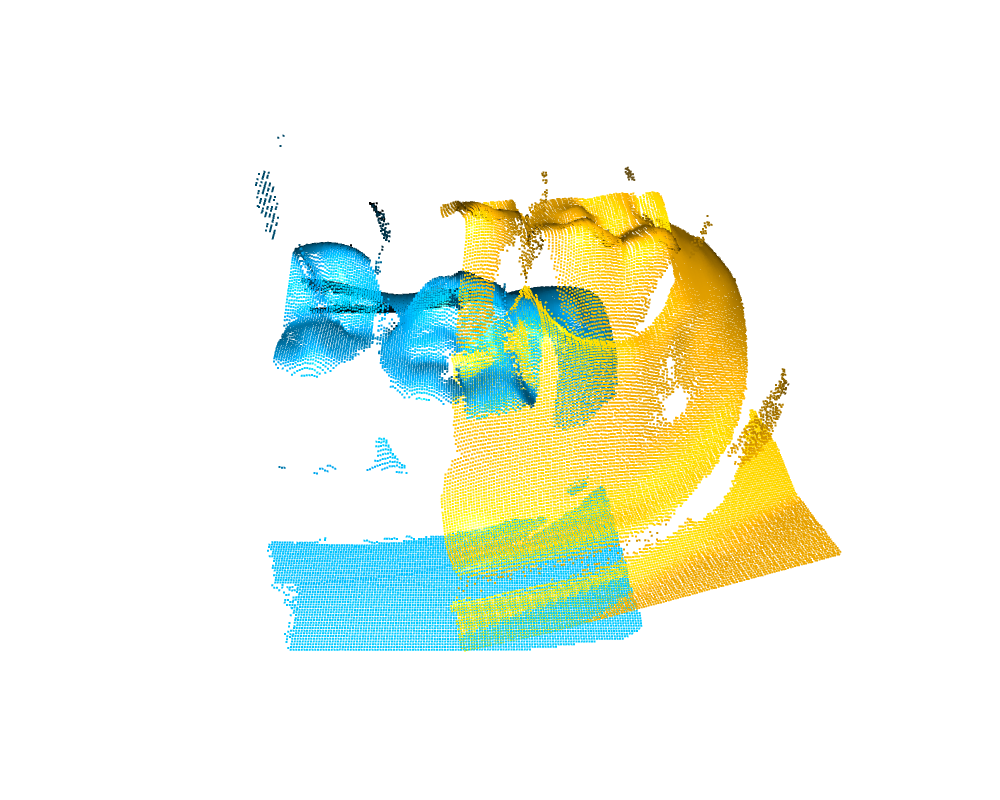

In [27]:
newest = last_file_containing("tooth_0_External_Upper", extension = '.png')
Im(filename=newest,width = 400)

Seems an hard task to fulfill for the global + icp registration with these inputs, we tried with different ones, for the same tooth and here below the result.

In [30]:
t = 0 # tooth we want to reconstruct
i = 1 # 0=external , 1= internal
j = 2 # 2 =upper
source = list_sequences[i][t]
target = list_sequences[j][t]
mytitle = "tooth_%s_%s_%s"%(t,labels[i],labels[j])

new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= ["%s"%labels[i],"%s"%labels[j]],
                                                                    mytitle = mytitle,
        
                                                                    # cleaning up before stitching        
                                                                    add_outlier_removal = True,

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 30000,

                                                                    #registration
                                                                    voxel_size = 0.2, # with 0.1 doesnt work, with 0.3 takes longer
                                                                    mmax_iteration = 10**6,
                                                                    mmax_validation = 0.7, #with 0.5 takes longer

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.70, # heuristic
                                                                    maxnumattempts = 10, # the default is 30

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = True,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = False,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )


tooth_0_Internal_Upper

outlier removal

DOWNSAMPLING BIG CLOUDS

Internal
Processed Internal has 19941 points 

Upper
Processed Upper has 20706 points 

DATA PREPARATION
removing outliers
value to reach:  14494.199999999999
source has 19941 points
target has 20706 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=7.992565e-02, inlier_rmse=1.851942e-01, and correspondence_set size of 215
Access transformation to get result.
Transformation is:
[[  0.96368234  -0.05808151   0.26065855 -13.83336061]
 [ -0.12684367   0.75937954   0.63816408 -31.67498276]
 [ -0.23500431  -0.64805034   0.72443338  13.97930179]
 [  0.           0.           0.           1.        ]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=7.653578e-01, inlier_rmse=1.089217e-01, a

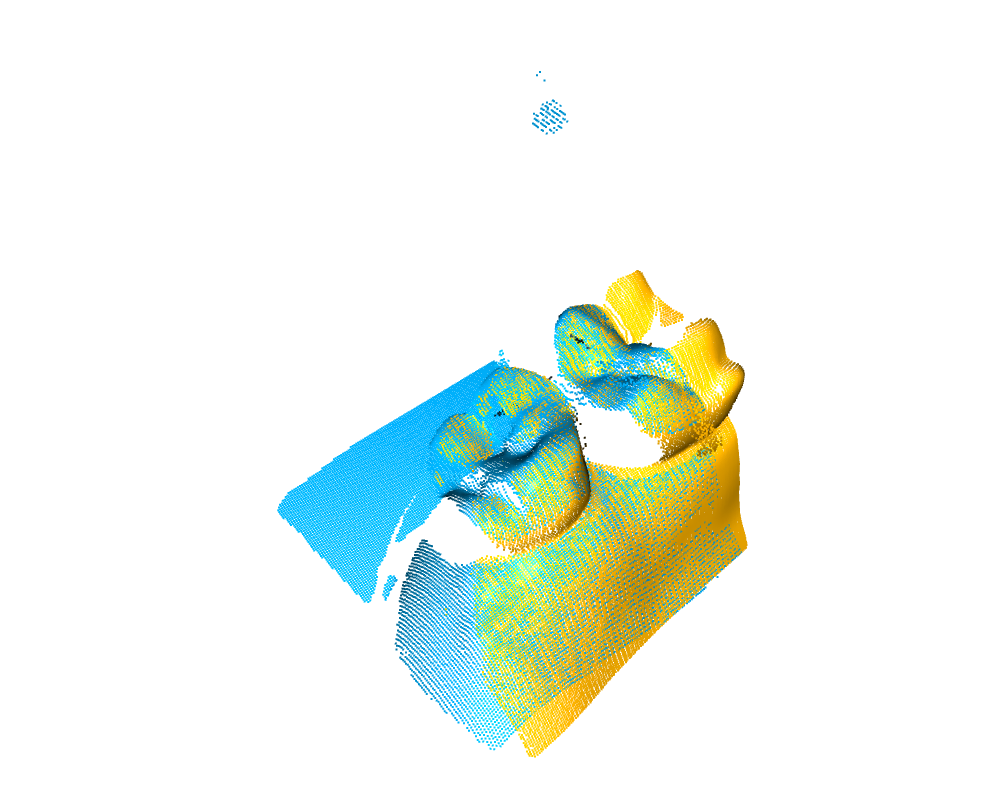

In [24]:
newest = last_file_containing("tooth_0_Internal_Upper", extension = '.png')
Im(filename=newest,width = 400)

Choosing different inputs, namely Internal and Upper pcl, the result seems better, but maybe building tooth by tooth is not the best choice. 

## Stitching sequences 

After trying to stitch toghether the point clouds capturing one tooth (one external pcl, one internal and one upper pcl) we realized that this was possible, but really unstable: the registration functions would often fall in local minima due to not enough overlapping points.  

Therefore the following successful approach has been implemented, we stich the continuous sequences, and being the point clouds in sequence we expect the overlapping in a proper stitching to be high.
More stable results were obtained,but sometimes we would still get stuck in sub obtimal solution, therefore we put a condition:

>* while overlapping_points < quality_condition
    * do execute_global_registration
    * do refine_registration
    
where 

> overlapping_points = len(np.asarray(result_icp.correspondence_set))

> quality_condition = myoverlapping_factor*(len(np.asarray(target.points)))

The correspondence set is returned as one of the results of the registration process (both global and icp) and we noticed that when the registration was successful according to a qualitative evaluation (by looking at it)the value of the correspondence set was very high: over a target cloud of ca 20.000 points at least ca 15000 where found overlapping. 

For step by step comments, please check the function itself under notebook "stitching clean".

Note that:
* prints_statements set to True give the verbose output, in which transformation matrix and metrics are printed.
* Also note that with "visualization on" statement as True, all intermediate results of the stitching are shown ( and you need to close the pop up windows while they appear).
* If the "final_vis_on" is set to True,only the final stitch of one sequence is going to be plotted. 

In the pipeline implementation we will not print one by one the stitching, but here they are for clarity.
Also note that in the py files the backbone of the stitching is kept.

In [70]:
#for this_sequence in list_sequences:
t = 0
list_new_pointclouds = []
all_results = []

dt_string = mytimestamp()
mytitle = "PointClouds_%s"%t

for t in tqdm(list(range(9))):
    print(dash)
    mytitle = mytitle +"-%s"%(t+1)
    #print (mytitle)

    if len(list_new_pointclouds) == 0:
        source = list_sequences[0][t]
    else:
        source = list_new_pointclouds[-1]

    target = list_sequences[0][t+1]    
    
    new_source, new_target, newpointcloud ,this_all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= ["%s"%t,"%s"%(t+1)],
                                                                    mytitle = mytitle,
        
                                                                    # cleaning up before stitching        
                                                                    add_outlier_removal = True,

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 30000,

                                                                    #registration
                                                                    voxel_size = 0.2, # with 0.1 doesnt work, with 0.3 takes longer
                                                                    mmax_iteration = 10**6,
                                                                    mmax_validation = 0.7, #with 0.5 takes longer

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.75, # heuristic
                                                                    maxnumattempts = 10, # the default is 30

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = True,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = False,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )
    all_results .append(this_all_results)
    list_new_pointclouds.append(newpointcloud)

  0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
PointClouds_0-1

outlier removal

DOWNSAMPLING BIG CLOUDS

0
Processed 0 has 23083 points 

1
Processed 1 has 24265 points 

DATA PREPARATION
removing outliers
value to reach:  18198.75
source has 23083 points
target has 24265 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=4.184795e-01, inlier_rmse=1.360975e-01, and correspondence_set size of 3655
Access transformation to get result.
Transformation is:
[[ 9.99944300e-01 -9.84078906e-03  3.81529530e-03  1.74992312e+00]
 [ 9.83473941e-03  9.99950356e-01  1.60116204e-03 -3.45956061e-02]
 [-3.83086260e-03 -1.56355042e-03  9.99991440e-01 -3.89489671e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

POINT-TO-PLANE ICP registration is applied on original point
distance

Downsampling 5 from 65789 points with voxel size 0.15 
Downsampling 5 from 39377 points with voxel size 0.2 
Processed 5 has 24520 points 

6
Processed 6 has 23453 points 

DATA PREPARATION
removing outliers
value to reach:  17589.75
source has 139627 points
target has 23453 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=3.424386e-02, inlier_rmse=2.147723e-01, and correspondence_set size of 173
Access transformation to get result.
Transformation is:
[[ 0.99250802  0.02821038  0.11887809 -3.0578032 ]
 [-0.02124736  0.99800581 -0.05943861  2.66081322]
 [-0.12031781  0.05646745  0.99112817  0.73503378]
 [ 0.          0.          0.          1.        ]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=6.378279e-01, inlier_rmse=7.917382e-02, and cor

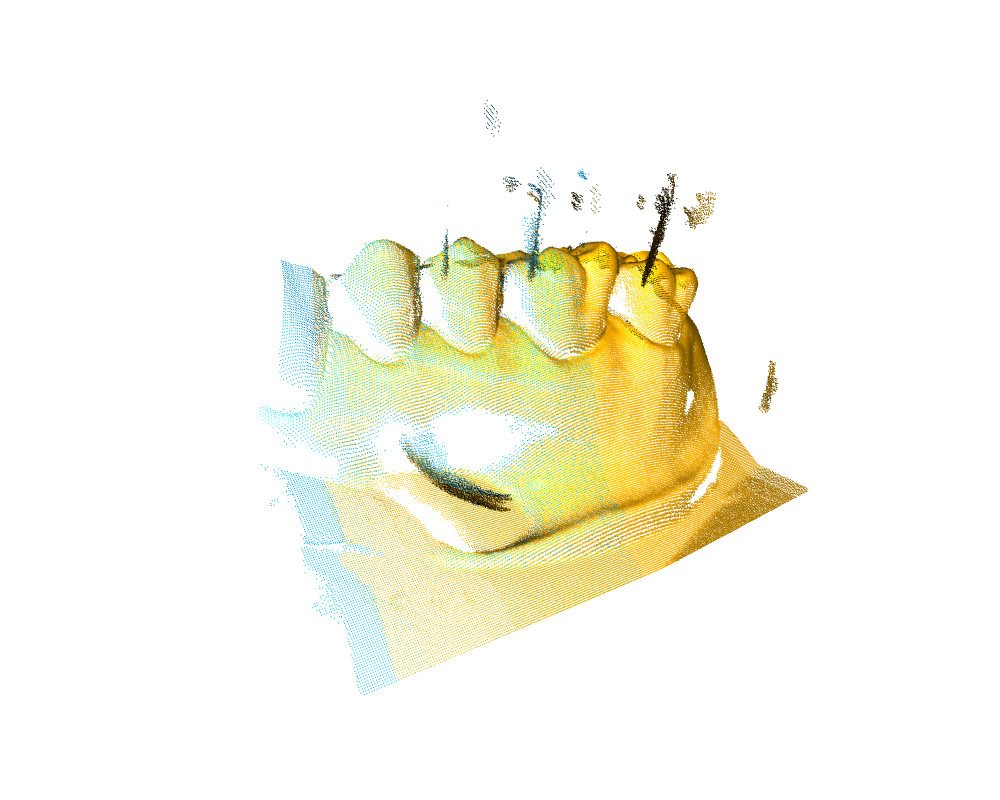

In [10]:
# lets visualize our point cloud
stitched_seq_1 = list_new_pointclouds[-1]
tstring = mytimestamp()

custom_draw_geometry(stitched_seq_1,
                     mytitle = tstring+"stitched_seq_1",
                     params = specific_screen,  # parameter for camera point view, json file via pressing P
                     configuration_file = specific_render, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)

## if you want to visualize your last just uncomment the first line and comment the second
#newest = last_file_containing(tstring+"stitched_seq_1", extension = '.png')
newest = last_file_containing("initial_stitched_seq_1", extension = '.png')
Im(filename=newest,width = 800)

In [71]:
#collect registration results
icp_results = []
global_results = []

x_label = []
seqt = "Seq-0"
for t in range(len(all_results)):
    x_label.append(seqt)
    for k,v in all_results[t].items():
        seqt += "-%s"%(t+1)
        print (f"\n{seqt}")
        print (f" GLOBAL: \n  {v[0]} ")
        print (f" ICP: \n {v[1]} ")
        
        global_results.append(v[0])
        icp_results.append(v[1])



Seq-0-1
 GLOBAL: 
  RegistrationResult with fitness=4.184795e-01, inlier_rmse=1.360975e-01, and correspondence_set size of 3655
Access transformation to get result. 
 ICP: 
 RegistrationResult with fitness=9.250531e-01, inlier_rmse=7.526553e-02, and correspondence_set size of 21353
Access transformation to get result. 

Seq-0-1-2
 GLOBAL: 
  RegistrationResult with fitness=2.117552e-01, inlier_rmse=1.594348e-01, and correspondence_set size of 1315
Access transformation to get result. 
 ICP: 
 RegistrationResult with fitness=8.580080e-01, inlier_rmse=7.441488e-02, and correspondence_set size of 39954
Access transformation to get result. 

Seq-0-1-2-3
 GLOBAL: 
  RegistrationResult with fitness=2.099738e-01, inlier_rmse=1.933239e-01, and correspondence_set size of 1280
Access transformation to get result. 
 ICP: 
 RegistrationResult with fitness=8.036216e-01, inlier_rmse=7.357268e-02, and correspondence_set size of 56096
Access transformation to get result. 

Seq-0-1-2-3-4
 GLOBAL: 
  R

In [72]:
#plot the fitness function of all the attempts

x = list(range(1,len(icp_results)+1,1))
# red dashes, blue squares and green triangles
icp_fitness_list = [v.fitness for v in icp_results]
icp_inlier_rmse_list = [v.inlier_rmse for v in icp_results]
icp_correspondence_set_list = [len(np.asarray(v.correspondence_set)) for v in icp_results]

icp_parameters = [icp_fitness_list,icp_inlier_rmse_list,icp_correspondence_set_list]
icp_parameters_labels = ["icp_fitness_list","icp_inlier_rmse_list","icp_cum_correspondence_set_list"]

#symbols = ["o","^","s"]
colors = ["b","r","yellow"]

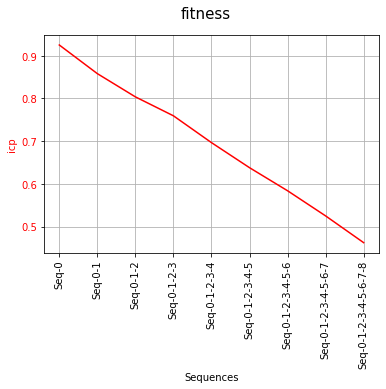

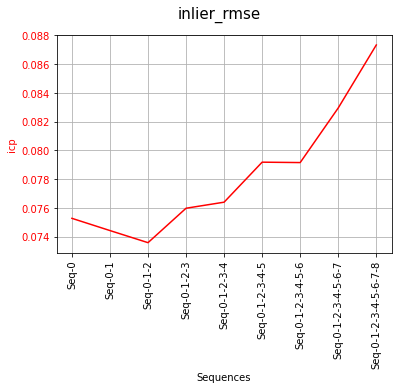

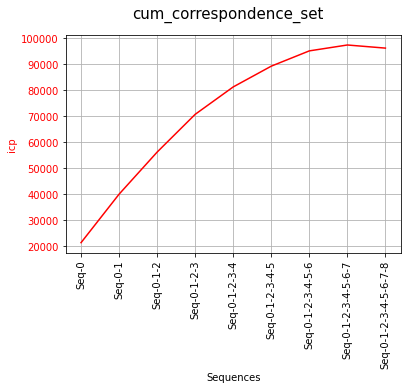

In [73]:
for i in range(len(icp_parameters_labels)):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(6, 4)
    
    fig.suptitle(f'{icp_parameters_labels[i][4:-5]}', fontsize=15)
    
    ax1.set_xlabel('Sequences')
    ax1.set_ylabel('icp', color=colors[1]) 
    
    ax1.plot(x, 
             icp_parameters[i],
             colors[1],
             #colors[1]+symbols[1], 
             label=icp_parameters_labels[i]) 
    ax1.tick_params(axis='y', labelcolor=colors[1])
    ax1.set_xticks(x, minor=False)
    ax1.set_xticklabels(x_label, minor=False)
    
    plt.xticks(rotation=90)
    plt.grid()
    plt.savefig("Sequential_stitching_plots")
    plt.show()

In [10]:
#for this_sequence in list_sequences:
t = 0
list_new_pointclouds = []

dt_string = mytimestamp()
mytitle = "PointClouds_%s"%t

for t in tqdm(list(range(9))):
    print(dash)
    mytitle = mytitle +"-%s"%(t+1)
    #print (mytitle)

    if len(list_new_pointclouds) == 0:
        source = list_sequences[1][t]
    else:
        source = list_new_pointclouds[-1]

    target = list_sequences[1][t+1]    
    
    new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= ["%s"%t,"%s"%(t+1)],
                                                                    mytitle = mytitle,
        
                                                                    # cleaning up before stitching
                                                                    add_outlier_removal = True,

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 30000,

                                                                    #registration
                                                                    voxel_size = 0.2,
                                                                    mmax_iteration = 10**6,
                                                                    mmax_validation = 0.7,

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.75,
                                                                    maxnumattempts = 10,

                                                                    # visualization and printing parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = False,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = False,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )

    list_new_pointclouds.append(newpointcloud)

--------------------------------------------------------------------------------
PointClouds_0-1
--------------------------------------------------------------------------------
PointClouds_0-1-2
--------------------------------------------------------------------------------
PointClouds_0-1-2-3
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8-9



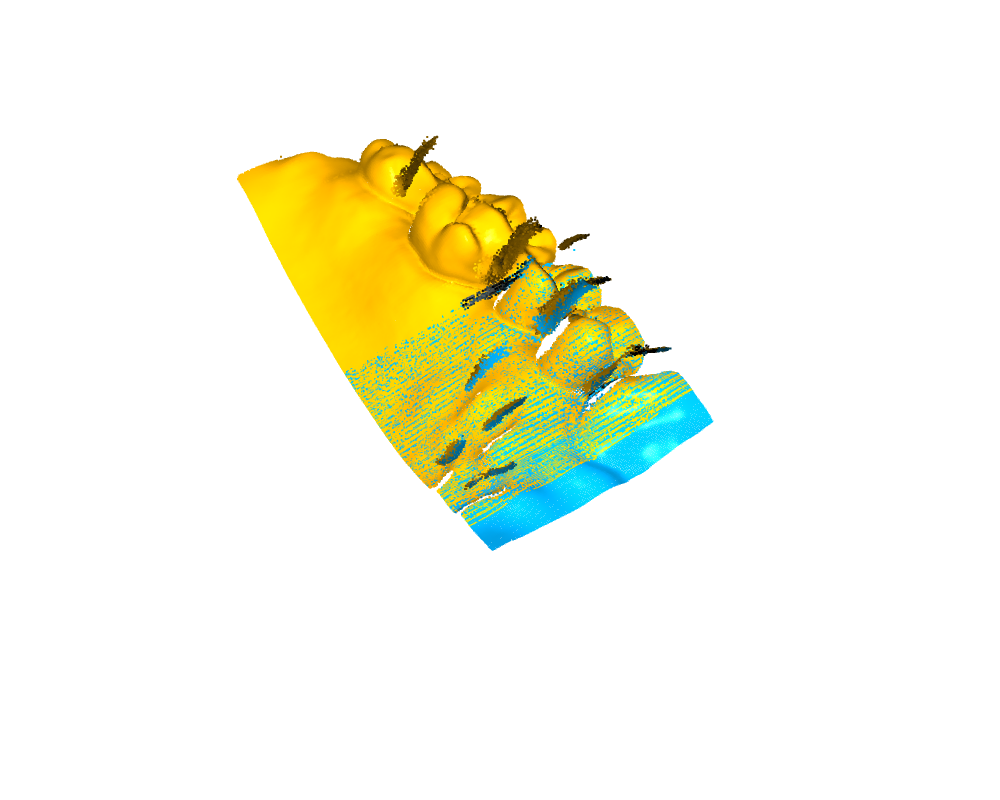

In [11]:
stitched_seq_2 = list_new_pointclouds[-1]
tstring = mytimestamp()

custom_draw_geometry(stitched_seq_2,
                     mytitle = tstring+"stitched_seq_2",
                     params = specific_screen,  # parameter for camera point view, json file via pressing P
                     configuration_file = specific_render, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)

newest = last_file_containing("stitched_seq_2", extension = '.png')
Im(filename=newest,width = 800)

In [12]:
#for this_sequence in list_sequences:
t = 0
list_new_pointclouds = []

dt_string = mytimestamp()
mytitle = "PointClouds_%s"%t

for t in tqdm(list(range(9))):
    print(dash)
    mytitle = mytitle +"-%s"%(t+1)
    #print (mytitle)

    if len(list_new_pointclouds) == 0:
        source = list_sequences[2][t]
    else:
        source = list_new_pointclouds[-1]

    target = list_sequences[2][t+1]    
    
    new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= ["%s"%t,"%s"%(t+1)],
                                                                    mytitle = mytitle,
        
                                                                    # cleaning up before stitching
                                                                    add_outlier_removal = True,

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 30000,

                                                                    #registration
                                                                    voxel_size = 0.2,
                                                                    mmax_iteration = 10**6,
                                                                    mmax_validation = 0.7,

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.75,
                                                                    maxnumattempts = 10,

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = False,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = False,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )

    list_new_pointclouds.append(newpointcloud)

--------------------------------------------------------------------------------
PointClouds_0-1
--------------------------------------------------------------------------------
PointClouds_0-1-2
--------------------------------------------------------------------------------
PointClouds_0-1-2-3
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8
--------------------------------------------------------------------------------
PointClouds_0-1-2-3-4-5-6-7-8-9



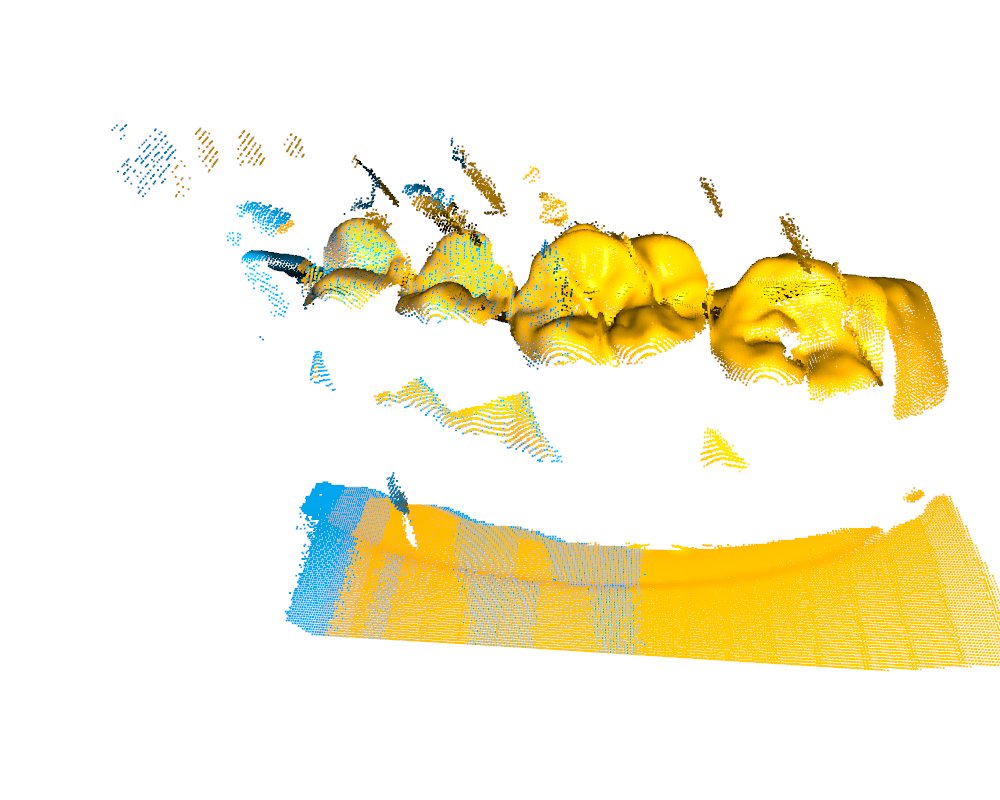

In [13]:
stitched_seq_3 = list_new_pointclouds[-1]
tstring = mytimestamp()

custom_draw_geometry(stitched_seq_3,
                     mytitle = "stitched_seq_3",
                     params = specific_screen,  # parameter for camera point view, json file via pressing P
                     configuration_file = specific_render, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)

newest = last_file_containing("stitched_seq_3", extension = '.png')
Im(filename=newest,width = 800)

In [14]:
## list of stitched sequences and 
## change colors if you wish...
all_stitched_sequences = [stitched_seq_1.paint_uniform_color([0.4, 0.4, 0.0]),
                          stitched_seq_2.paint_uniform_color([0.0, 0.4, 0.4]),
                          stitched_seq_3.paint_uniform_color([0.3, 0.0, 0.4])
                         ]

## results visualizations

Just to have a glimpse of all of them together without any alignment... 

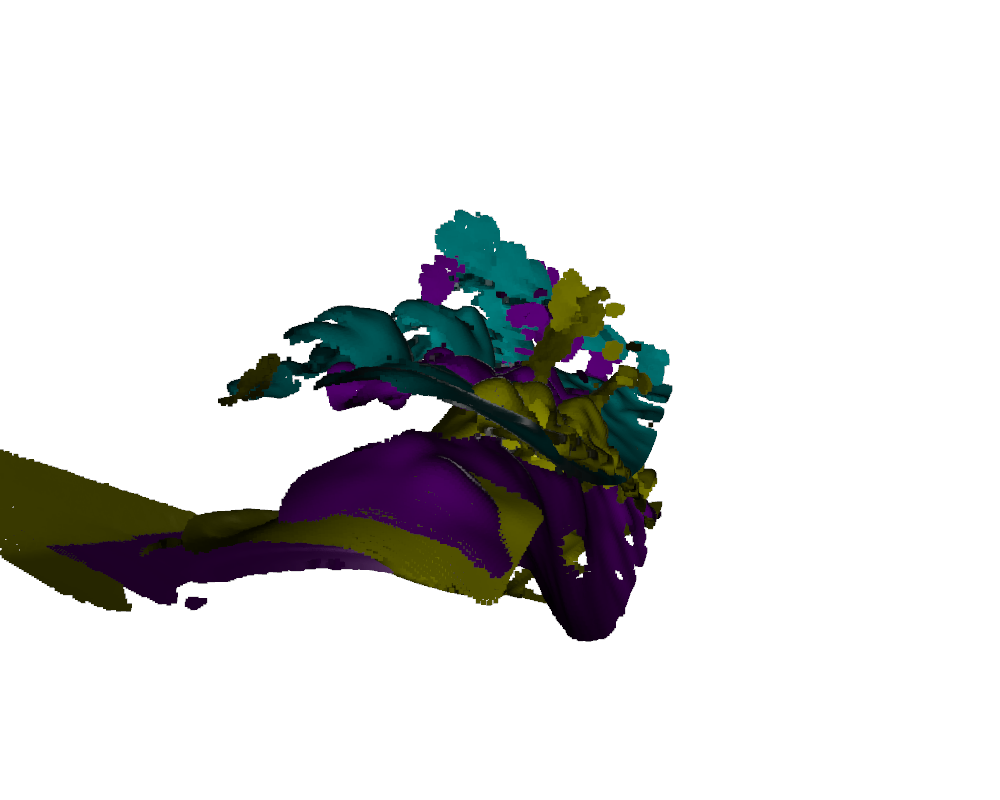

In [15]:
## all together
tstring = mytimestamp()
custom_draw_geometry(
                     stitched_seq_1+stitched_seq_2+stitched_seq_3,
                     mytitle = tstring+"all_three_sequences",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False,
                     onewindow = True
                    )
# after manual changing in visualization mode
newest = last_file_containing(tstring+"all_three_sequences", extension = '.png')
Im(filename=newest,width = 800)

## store locally

the official is store and gets loaded in next notebook, the current is stored with timestamp

In [16]:
dtstring = mytimestamp()
for i, seq in enumerate(all_stitched_sequences):
    o3d.io.write_point_cloud("../data/"+dt_string+"stitched_seq_%s.pcd"%i, seq)
    